<a href="https://colab.research.google.com/github/kdwang1808/stock/blob/master/4_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
import sys
os.chdir('drive/Colab Notebooks/Sentiment')

In [107]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import re
from tqdm import tqdm

In [26]:
from keras.utils import to_categorical
import random
import tensorflow
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential

tensorflow.random.set_seed(123)
random.seed(123)

In [234]:
sentence = pd.read_csv("4_sentence.csv", delimiter = '\t', header = None)
train_size = int(0.7 * sentence.shape[0])
train = sentence.iloc[0:train_size,:]
test = sentence.iloc[train_size:, :]

In [22]:
def clean_sentences(df):
    reviews = []

    for sent in tqdm(df[1]):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

In [31]:
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)
print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 825/825 [05:31<00:00,  2.49it/s]

1923
825


In [34]:
train_sentences[1]

['good', 'case', 'excellent', 'value']

In [90]:
target=train[0].values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [91]:
X_train,X_val,y_train,y_val = train_test_split(train_sentences,y_target,test_size=0.2,stratify=y_target)

In [92]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████| 1538/1538 [00:00<00:00, 343769.76it/s]

2510
32


In [93]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

#texts_to_sequences(texts)

    # Arguments- texts: list of texts to turn to sequences.
    #Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)

print(X_train.shape,X_val.shape,X_test.shape)

(1538, 32) (385, 32) (825, 32)


In [94]:
early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

In [97]:
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 32, 300)           753000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 32, 32)            42624     
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_9 (Dense)              (None, 100)               3300      
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 202       
Total params: 807,446
Trainable params: 807,446
Non-trainable params: 0
________________________________________________

In [98]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=3, batch_size=256, verbose=1, callbacks=callback)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1538 samples, validate on 385 samples
Epoch 1/3
1538/1538 [==============================] - 2s 1ms/step - loss: 0.6915 - accuracy: 0.5072 - val_loss: 0.6833 - val_accuracy: 0.5195
Epoch 2/3
 256/1538 [===>..........................] - ETA: 0s - loss: 0.6770 - accuracy: 0.5742

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1538/1538 [==============================] - 1s 723us/step - loss: 0.6669 - accuracy: 0.5949 - val_loss: 0.6181 - val_accuracy: 0.7506
Epoch 3/3
1538/1538 [==============================] - 1s 700us/step - loss: 0.5543 - accuracy: 0.7542 - val_loss: 0.4754 - val_accuracy: 0.7766


Text(0, 0.5, 'Loss')

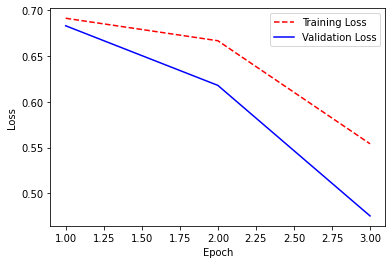

In [99]:
# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [100]:
y_pred = model.predict_classes(X_test)
test_acc = y_pred - np.array(test[0])
np.sum(test_acc==0)/len(test_acc)

0.6703030303030303

## 第二种net

In [235]:
df1 = pd.read_csv('labeledTrainData.tsv', delimiter="\t")
df1 = df1.drop(['id'], axis=1)
df1.columns = [0,1]

In [236]:
train = pd.concat([df1.iloc[0:5000,:], train], axis = 0)
train.head()

,0,1
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [153]:
test

,0,1
1923,0,The RI style calamari was a joke.
1924,0,"However, there was so much garlic in the fondu..."
1925,0,"I could barely stomach the meal, but didn't co..."
1926,0,"It was so bad, I had lost the heart to finish it."
1927,0,It also took her forever to bring us the check...
...,...,...
2743,0,I just got bored watching Jessice Lange take h...
2744,0,"Unfortunately, any virtue in this film's produ..."
2745,0,"In a word, it is embarrassing."
2746,0,Exceptionally bad!


In [105]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix


import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from importlib import reload
import sys
from imp import reload

if sys.version[0] == '2':
    reload(sys)
    sys.setdefaultencoding("utf-8")

In [108]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

##

def lemmatize(tokens: list) -> list:
    # 1. Lemmatize 词形还原 去掉单词的词缀 比如，单词“cars”词形还原后的单词为“car”，单词“ate”词形还原后的单词为“eat”
    tokens = list(map(lemmatizer.lemmatize, tokens))
    lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), tokens))
    # 2. Remove stop words 删除停用词
    meaningful_words = list(filter(lambda x: not x in stop_words, lemmatized_tokens))
    return meaningful_words


def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Lemmatize
    lemmas = lemmatize(tokens)
    # 4. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

In [237]:
train['Processed_Reviews'] = train[1].apply(lambda x: clean_text(x))
train.head()

,0,1,Processed_Reviews
0,1,With all this stuff going down at the moment w...,stuff go moment mj ive start listen music watc...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi...",classic war world timothy hines entertain film...
2,0,The film starts with a manager (Nicholas Bell)...,film start manager nicholas bell give welcome ...
3,0,It must be assumed that those who praised this...,must assume praise film greatest film opera ev...
4,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80 ex...


In [254]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 2000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['Processed_Reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(train['Processed_Reviews'])

maxlen = 100
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = train[0]

embed_size = 128
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(8, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(5, activation="relu"))
model.add(Dropout(0.8))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 10
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 5538 samples, validate on 1385 samples
Epoch 1/10
5538/5538 [==============================] - 7s 1ms/step - loss: 0.6911 - accuracy: 0.5209 - val_loss: 0.6873 - val_accuracy: 0.5350
Epoch 2/10
5538/5538 [==============================] - 6s 1ms/step - loss: 0.6738 - accuracy: 0.5536 - val_loss: 0.6661 - val_accuracy: 0.6686
Epoch 3/10
5538/5538 [==============================] - 6s 1ms/step - loss: 0.6288 - accuracy: 0.6304 - val_loss: 0.6545 - val_accuracy: 0.7061
Epoch 4/10
5538/5538 [==============================] - 6s 1ms/step - loss: 0.5870 - accuracy: 0.6598 - val_loss: 0.6317 - val_accuracy: 0.7134
Epoch 5/10
5538/5538 [==============================] - 6s 1ms/step - loss: 0.5531 - accuracy: 0.6853 - val_loss: 0.6123 - val_accuracy: 0.7271
Epoch 6/10
5538/5538 [==============================] - 6s 1ms/step - loss: 0.5479 - accuracy: 0.6871 - val_loss: 0.6021 - val_accuracy: 0.7480
Epoch 7/10
5538/5538 [==============================] - 6s 1ms/step - loss: 0.5356 - acc

In [239]:
model.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, None, 128)         256000    
_________________________________________________________________
bidirectional_29 (Bidirectio (None, None, 32)          18560     
_________________________________________________________________
global_max_pooling1d_29 (Glo (None, 32)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 10)                330       
_________________________________________________________________
dropout_34 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 11        
Total params: 274,901
Trainable params: 274,901
Non-trainable params: 0
_______________________________________________

In [255]:
test[1]=test[1].apply(lambda x: clean_text(x))
y_test = test[0]
list_sentences_test = test[1]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction = model.predict(X_te)
y_pred = (prediction > 0.5)

In [256]:
from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')
confusion_matrix(y_pred, y_test)

F1-score: 0.7882187938288919
Confusion matrix:


array([[393, 108],
       [ 43, 281]])